In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
busstop_weight = pd.read_csv("../data/bustop_pop.csv")
all_pop = pd.read_csv("../data/total_data.csv")
all_pop["총인구수"] = all_pop["총인구수"].apply(lambda x: int(x.replace(",", "")))
all_pop["노인(수)"] = all_pop["노인(수)"].apply(lambda x: int(x.replace(",", "")))

city_code = pd.DataFrame([
    {"citycode":38010,"city_name":"창원시"},
    {"citycode":38030,"city_name":"진주시"},
    {"citycode":38050,"city_name":"통영시"},
    {"citycode":38060,"city_name":"사천시"},
    {"citycode":38070,"city_name":"김해시"},
    {"citycode":38080,"city_name":"밀양시"},
    {"citycode":38090,"city_name":"거제시"},
    {"citycode":38100,"city_name":"양산시"},
    {"citycode":38310,"city_name":"의령군"},
    {"citycode":38320,"city_name":"함안군"},
    {"citycode":38330,"city_name":"창녕군"},
    {"citycode":38340,"city_name":"고성군"},
    {"citycode":38350,"city_name":"남해군"},
    {"citycode":38360,"city_name":"하동군"},
    {"citycode":38370,"city_name":"산청군"},
    {"citycode":38380,"city_name":"함양군"},
    {"citycode":38390,"city_name":"거창군"},
    {"citycode":38400,"city_name":"합천군"}
    ])

all_pop = pd.merge(all_pop, city_code, on="city_name", how="left")
all_pop = all_pop[["city_name", "citycode", "총인구수", "노인(수)"]].drop_duplicates()
all_pop = all_pop.rename(columns={"citycode" : "도시코드"})
busstop_weight = pd.merge(busstop_weight, all_pop[[ "도시코드", "총인구수", "노인(수)"]], on="도시코드", how="left")

In [3]:
busstop_weight = busstop_weight.rename(columns={
    "weight" : "이용량",
    "읍면동인구수" : "행정동_노인_인구수", 
    "노인(수)" : "노인_인구수"
    })

In [4]:
busstop_weight.columns

Index(['정류장번호', '정류장명', '위도', '경도', '정보수집일', '모바일단축번호', '도시코드', '도시명', '관리도시명',
       'geometry', '이용량', '행정동_노인_인구수', '총인구수', '노인_인구수'],
      dtype='object')

In [5]:
use_col = ['정류장번호', '정류장명', '위도', '경도', '도시코드', '도시명', 'geometry', '이용량', '행정동_노인_인구수', '총인구수', '노인_인구수']

In [6]:
busstop_weight = busstop_weight[use_col]

## 활용성 지수

### 1. 활용성 지수 변수 생성

In [7]:
# 노인 인구 대비 이용량 비율
busstop_weight['노인_이용량_비율'] = busstop_weight['행정동_노인_인구수'] / busstop_weight['총인구수']
# 노인 인구 밀집도
busstop_weight['노인_밀집도'] = busstop_weight['노인_인구수'] / busstop_weight['총인구수']
# 활용성 지표 계산 (노인 이용량 비율과 노인 밀집도를 종합)
busstop_weight['활용성'] = busstop_weight['노인_이용량_비율'] * busstop_weight['이용량']

In [8]:
busstop_weight.head()

,정류장번호,정류장명,위도,경도,도시코드,도시명,geometry,이용량,행정동_노인_인구수,총인구수,노인_인구수,노인_이용량_비율,노인_밀집도,활용성
0,CWB379000566,구암고등학교,35.246296,128.593978,38010,경상남도 창원시,POINT (1099529.3099473445 1695090.3215359906),478654.0,410959,1003731,276574,0.409431,0.275546,1.959760e+05
1,CWB379000567,사격장입구,35.244923,128.683156,38010,경상남도 창원시,POINT (1107644.8457543373 1695031.1020157929),464401.0,1934447,1003731,276574,1.927256,0.275546,8.950198e+05
2,CWB379000568,장애인복지회관입구,35.244960,128.673597,38010,경상남도 창원시,POINT (1106775.0680812967 1695024.859684883),732161.0,1934447,1003731,276574,1.927256,0.275546,1.411062e+06
3,CWB379000570,장애인복지회관입구,35.244773,128.673243,38010,경상남도 창원시,POINT (1106743.105090053 1695003.6802969584),266638.0,1934447,1003731,276574,1.927256,0.275546,5.138798e+05
4,CWB379000573,지귀상가,35.244778,128.659437,38010,경상남도 창원시,POINT (1105486.9448440736 1694989.4555102403),1120637.0,1934447,1003731,276574,1.927256,0.275546,2.159755e+06


### 2. 활용성 정규화

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
busstop_weight["활용성"] = scaler.fit_transform(busstop_weight[["활용성"]])

In [50]:
busstop_weight["활용성"]

0        0.010307
1        0.047073
2        0.074214
3        0.027027
4        0.113591
           ...   
19023    0.001073
19024    0.049768
19025    0.049768
19026    0.049768
19027    0.049768
Name: 활용성, Length: 19028, dtype: float64

## 대중교통 이용 지수

In [17]:
import pickle
with open("../data/거리계산/silver_dist_result_df.pkl", "rb") as f:
    silver_dist = pickle.load(f)
with open("../data/거리계산/silver_location_results.pkl", "rb") as f:
    silver_loc = pickle.load(f)
    
with open("../data/거리계산/facility_dist_result_df.pkl", "rb") as f:
    facility_dist = pickle.load(f)
with open("../data/거리계산/facility_location_results.pkl", "rb") as f:
    facility_loc = pickle.load(f)

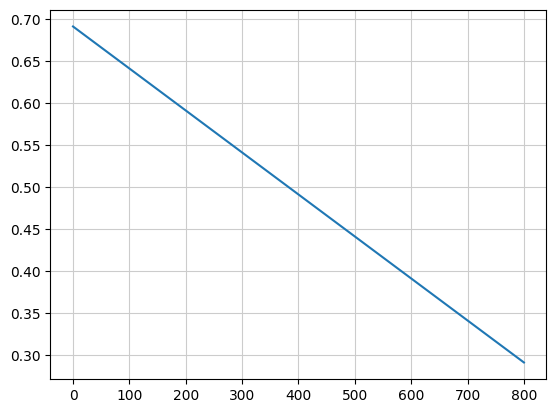

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 800, 0.01)
y = -0.0005 * x + 0.6913
plt.plot(x, y)
plt.grid(color="0.8")
plt.show()

In [90]:
silver_dist_m = silver_dist.copy()

In [91]:
silver_dist_m

,격자이름,정류장1,정류장2,정류장3,정류장4,정류장5,정류장6,정류장7,정류장8,정류장9,정류장10
0,마라008419,0.06514,0.06844,0.10365,0.11520,0.21657,0.23631,0.25837,0.54109,0.62606,0.68511
1,마라044519,0.05491,0.29943,0.44611,0.39567,0.45354,0.41379,0.41208,0.48723,0.49330,0.49434
2,라라975559,0.05329,0.22805,0.25535,0.34416,0.49523,0.51234,0.45042,0.48138,0.52039,0.65750
3,마라087557,0.13193,0.15839,0.16444,0.14129,0.21862,0.19752,0.23882,0.25938,0.31876,0.32032
4,마라039555,0.14237,0.14216,0.21804,0.22857,0.25185,0.29083,0.30261,0.32036,0.32756,0.40219
...,...,...,...,...,...,...,...,...,...,...,...
26581,라마600304,0.11146,0.57636,0.80245,0.80751,0.70310,0.70273,1.25401,1.25596,1.39804,1.41769
26582,라마664324,0.21349,0.83838,0.87067,0.92060,0.82883,0.84330,1.03419,1.04902,1.14859,1.15094
26583,라마710315,0.25587,0.27319,0.27302,0.52652,0.53484,0.66246,0.66735,0.65976,0.83799,1.20471
26584,라마565506,0.16256,0.16746,0.40994,0.41053,0.71931,1.44938,1.45171,1.69819,1.70028,1.62561


In [92]:
## 인덱스 격자이름으로 설정
silver_dist_m = silver_dist_m.set_index("격자이름")

## km에서 m로 변환
silver_dist_m = silver_dist_m*1000

## 800m 이상만 가져오기
silver_dist_m = silver_dist_m[silver_dist_m <= 800]

In [94]:
silver_dist_m.head()

,정류장1,정류장2,정류장3,정류장4,정류장5,정류장6,정류장7,정류장8,정류장9,정류장10
격자이름,,,,,,,,,,
마라008419,65.14,68.44,103.65,115.20,216.57,236.31,258.37,541.09,626.06,685.11
마라044519,54.91,299.43,446.11,395.67,453.54,413.79,412.08,487.23,493.30,494.34
라라975559,53.29,228.05,255.35,344.16,495.23,512.34,450.42,481.38,520.39,657.50
마라087557,131.93,158.39,164.44,141.29,218.62,197.52,238.82,259.38,318.76,320.32
마라039555,142.37,142.16,218.04,228.57,251.85,290.83,302.61,320.36,327.56,402.19


In [95]:
## 대중교통 이용 지수 설정
silver_dist_idx = silver_dist_m.applymap(lambda x: -0.0005 * x + 0.6913 if not pd.isnull(x) else np.nan)

In [96]:
silver_dist_idx.head()

,정류장1,정류장2,정류장3,정류장4,정류장5,정류장6,정류장7,정류장8,정류장9,정류장10
격자이름,,,,,,,,,,
마라008419,0.658730,0.657080,0.639475,0.633700,0.583015,0.573145,0.562115,0.420755,0.378270,0.348745
마라044519,0.663845,0.541585,0.468245,0.493465,0.464530,0.484405,0.485260,0.447685,0.444650,0.444130
라라975559,0.664655,0.577275,0.563625,0.519220,0.443685,0.435130,0.466090,0.450610,0.431105,0.362550
마라087557,0.625335,0.612105,0.609080,0.620655,0.581990,0.592540,0.571890,0.561610,0.531920,0.531140
마라039555,0.620115,0.620220,0.582280,0.577015,0.565375,0.545885,0.539995,0.531120,0.527520,0.490205


### 거리 계산 다시 진행한 후 실행

In [152]:
busstop_weight = busstop_weight.rename(columns={"정류장번호" : "nodeid"})

## 활용성 지수 설정
from tqdm import tqdm
act_list = []
for id in tqdm(silver_dist_m.index):
    act_ = pd.merge(pd.DataFrame(silver_loc[id]), busstop_weight[["nodeid", "활용성"]], on="nodeid", how="left")
    act_list.append(act_["활용성"].values)

  0%|          | 0/26586 [00:00<?, ?it/s]

100%|██████████| 26586/26586 [04:09<00:00, 106.63it/s]


In [153]:
silver_act_idx = pd.DataFrame(act_list)

In [154]:
silver_act_idx

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.002218,0.000261,0.001538,0.002165,0.005081,0.000952,0.007250,0.002218,0.002348,0.004626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.003398,0.003398,0.006048,0.005138,0.005374,0.007967,0.004464,0.001551,0.001963,0.007967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.004967,0.007718,0.023355,0.010579,0.002625,0.010579,0.023355,0.007718,0.047654,0.047654,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.002732,0.024732,0.021412,0.001905,0.002732,0.005601,0.016779,0.001905,0.000556,0.007101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000979,0.007849,0.008015,0.008015,0.046452,0.045474,0.059018,0.008015,0.008015,0.050195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26581,0.025656,0.000442,0.010493,0.009413,0.000442,0.000114,0.002093,0.002471,0.000707,0.000655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26582,0.000052,0.000687,0.000052,0.000679,0.000120,0.000132,0.000687,0.000629,0.000052,0.000051,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26583,0.000096,0.000136,0.000002,0.000002,0.000026,0.000111,0.000096,0.000024,0.000024,0.000088,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26584,0.000722,0.000899,0.000899,0.000722,0.000110,0.000722,0.000844,0.000722,0.000899,0.000413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
list(silver_act_idx.isna().sum())

[0,
 2,
 0,
 1,
 2,
 1,
 0,
 0,
 0,
 0,
 26465,
 26465,
 26465,
 26470,
 26470,
 26470,
 26487,
 26488,
 26488,
 26494,
 26497,
 26497,
 26533,
 26534,
 26534,
 26534,
 26534,
 26534,
 26537,
 26537,
 26568,
 26568,
 26568,
 26568,
 26570,
 26570,
 26570,
 26570,
 26570,
 26570,
 26570,
 26570,
 26570,
 26570,
 26570,
 26570,
 26570,
 26570,
 26570,
 26570,
 26570,
 26570,
 26570,
 26570,
 26570,
 26570,
 26570,
 26570,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
 26572,
